# Benchmarking cell2location pyro model using softplus/exp for scales

In [1]:
import sys, ast, os
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import matplotlib as mpl
data_type='float32'

#sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
#sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/software/pyro/')

import cell2location_model 

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/'

## Read datasets and train cell2location

Data can be downloaded as follows:

```bash
wget https://cell2location.cog.sanger.ac.uk/paper/synthetic_with_tissue_zones/synth_adata_real_mg_20210131.h5ad
wget https://cell2location.cog.sanger.ac.uk/paper/synthetic_with_tissue_zones/training_5705STDY8058280_5705STDY8058281_20210131.h5ad
```

In [3]:
adata_vis = anndata.read(f'{sp_data_folder}synth_adata_real_mg_20210131.h5ad')
adata_vis.uns['spatial'] = {'x': 'y'}
adata_vis = adata_vis[adata_vis.obs['sample'] == 'exper0',:]

adata_snrna_raw = anndata.read(f'{sp_data_folder}training_5705STDY8058280_5705STDY8058281_20210131.h5ad')

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [4]:
import scipy
adata_snrna_raw.X = scipy.sparse.csr_matrix(adata_snrna_raw.X)

In [5]:
adata_vis.X = scipy.sparse.csr_matrix(adata_vis.X)

Add counts matrix as `adata.raw` 

In [6]:
adata_snrna_raw.raw = adata_snrna_raw
adata_vis.raw = adata_vis

In [7]:
# compute average for each cluster
aver = cell2location_model.get_cluster_averages(adata_snrna_raw, 'annotation_1')

# make sure the order of gene matches between aver and x_data
aver = aver.loc[adata_vis.var_names,:]

# generate one-hot encoded matrix telling which obs belong to whic samples
obs2sample_df = pd.get_dummies(adata_vis.obs['sample'])

In [8]:
adata_vis

AnnData object with n_obs × n_vars = 2500 × 12809
    obs: 'cell_count_Inh_3', 'cell_count_Ext_Pir', 'cell_count_Oligo_2', 'cell_count_Astro_HYPO', 'cell_count_Ext_L25', 'cell_count_Astro_THAL_lat', 'cell_count_Ext_L5_1', 'cell_count_Ext_L23', 'cell_count_Micro', 'cell_count_Ext_Thal_1', 'cell_count_Ext_Hpc_CA1', 'cell_count_Inh_Meis2_3', 'cell_count_Inh_4', 'cell_count_OPC_1', 'cell_count_Oligo_1', 'cell_count_Ext_Hpc_CA3', 'cell_count_Astro_CTX', 'cell_count_Astro_THAL_med', 'cell_count_Inh_Vip', 'cell_count_Ext_Amy_2', 'cell_count_Astro_AMY_CTX', 'cell_count_Unk_1', 'cell_count_Inh_Sst', 'cell_count_Inh_Meis2_2', 'cell_count_Ext_Hpc_DG2', 'cell_count_Ext_Hpc_DG1', 'cell_count_Inh_1', 'cell_count_Inh_Meis2_4', 'cell_count_Inh_2', 'cell_count_Nb_1', 'cell_count_Ext_Thal_2', 'cell_count_Ext_Amy_1', 'cell_count_Ext_L6', 'cell_count_OPC_2', 'cell_count_Inh_Meis2_1', 'cell_count_Ext_L6B', 'cell_count_LowQ_2', 'cell_count_Ext_Unk_3', 'cell_count_Ext_L56', 'cell_count_Inh_Lamp5', 'cell_coun

## Model training

In [9]:
results_folder

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/'

In [10]:
#import torch
#torch.set_default_tensor_type(torch.cuda.FloatTensor)

mod = cell2location_model.LocationModelLinearDependentWMultiExperiment(
    n_obs=adata_vis.n_obs,
    n_vars=adata_vis.n_vars,
        n_factors=aver.shape[1],
        n_exper=obs2sample_df.shape[1],
        batch_size=None,
        cell_state_mat=aver.values.astype(data_type),
    )

from pyro.distributions import constraints
mod.guide.scale_constraint = constraints.positive
#mod.guide.scale_constraint = constraints.softplus_positive

#mod.to('cuda')
mod._train_full_data(x_data=adata_vis.raw.X.toarray().astype(data_type),
                     obs2sample=obs2sample_df.values.astype(data_type),
                     n_epochs=30000, lr=0.005)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [11]:
means = mod.guide.median()
means = {k: means[k].cpu().detach().numpy() 
         for k in means.keys()}

In [12]:
means

{'m_g_alpha_hyp': array(0.43943086, dtype=float32),
 'm_g_beta_hyp': array(8.669119, dtype=float32),
 'm_g': array([[2.8703711e-04, 5.3101081e-07, 4.9346332e-02, ..., 4.5412596e-04,
         4.8659127e-03, 1.8612338e-02]], dtype=float32),
 'n_s_cells_per_location': array([[9.676627],
        [9.703126],
        [9.487553],
        ...,
        [9.557752],
        [8.987891],
        [9.302585]], dtype=float32),
 'y_s_groups_per_location': array([[7.6170363],
        [7.4382005],
        [7.5281253],
        ...,
        [7.5786734],
        [7.8850822],
        [7.4004083]], dtype=float32),
 'z_sr_groups_factors': array([[8.98013916e-03, 9.79715865e-03, 2.83262858e-10, ...,
         9.47172847e-03, 2.68376450e-08, 1.09831020e-02],
        [9.91815794e-03, 1.16886524e-02, 2.97768199e-10, ...,
         9.63008404e-03, 1.66808775e-07, 1.03397975e-02],
        [9.55215469e-03, 8.56305100e-03, 1.82898710e-10, ...,
         9.71977599e-03, 8.30600939e-08, 1.08441617e-02],
        ...,
      

In [13]:
mod.model.m_g_shape

tensor(4., device='cuda:0')

In [14]:
mod.model.m_g_rate

tensor(8., device='cuda:0')

In [15]:
import inspect
import test
 
print(inspect.getsource(type(mod.guide)))

class AutoNormal(AutoGuide):
    """This implementation of :class:`AutoGuide` uses a Normal distribution
    with a diagonal covariance matrix to construct a guide over the entire
    latent space. The guide does not depend on the model's ``*args, **kwargs``.

    It should be equivalent to :class: `AutoDiagonalNormal` , but with
    more convenient site names and with better support for
    :class:`~pyro.infer.trace_mean_field_elbo.TraceMeanField_ELBO` .

    In :class:`AutoDiagonalNormal` , if your model has N named
    parameters with dimensions k_i and sum k_i = D, you get a single
    vector of length D for your mean, and a single vector of length D
    for sigmas.  This guide gives you N distinct normals that you can
    call by name.

    Usage::

        guide = AutoNormal(model)
        svi = SVI(model, guide, ...)

    :param callable model: A Pyro model.
    :param callable init_loc_fn: A per-site initialization function.
        See :ref:`autoguide-initialization` section f

In [16]:
mod.model.cell_number_prior["N_cells_per_location"]

8.0

In [17]:
from torch.distributions import constraints
from torch.distributions.transforms import Transform
from torch.nn.functional import softplus


def softplus_inv(y):
    return y + y.neg().expm1().neg().log()

class SoftplusTransform(Transform):
    r"""
    Transform via the mapping :math:`\text{Softplus}(x) = \log(1 + \exp(x))`.
    """
    domain = constraints.real
    codomain = constraints.positive
    bijective = True
    sign = +1

    def __eq__(self, other):
        return isinstance(other, SoftplusTransform)

    def _call(self, x):
        return softplus(x)

    def _inverse(self, y):
        return softplus_inv(y)

    def log_abs_det_jacobian(self, x, y):
        return -softplus(-x)
    

In [18]:
#SoftplusTransform()._inverse(torch.tensor(np.array([1])))

In [19]:
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)

mod_s = cell2location_model.LocationModelLinearDependentWMultiExperiment(
    n_obs=adata_vis.n_obs,
    n_vars=adata_vis.n_vars,
        n_factors=aver.shape[1],
        n_exper=obs2sample_df.shape[1],
        batch_size=None,
        cell_state_mat=aver.values.astype(data_type),
    )

from pyro.distributions import constraints
mod_s.guide.scale_constraint = constraints.softplus_positive
#mod_s.guide.scale_constraint = softplus_positive

#mod.cuda()
mod_s._train_full_data(x_data=adata_vis.raw.X.toarray().astype(data_type),
                    obs2sample=obs2sample_df.values.astype(data_type),
                    n_epochs=30000, lr=0.005)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [20]:
means_softplus = mod_s.guide.median()
means_softplus = {k: means_softplus[k].cpu().detach().numpy() 
                  for k in means_softplus.keys()}
means_softplus

{'m_g_alpha_hyp': array(0.44823322, dtype=float32),
 'm_g_beta_hyp': array(1.3109565, dtype=float32),
 'm_g': array([[1.9218922e-03, 2.8906165e-06, 3.6265948e-01, ..., 3.6861394e-03,
         4.4238470e-02, 1.2730496e-01]], dtype=float32),
 'n_s_cells_per_location': array([[8.977466 ],
        [9.206554 ],
        [7.8340926],
        ...,
        [7.9797125],
        [9.723162 ],
        [6.9123526]], dtype=float32),
 'y_s_groups_per_location': array([[15.841911],
        [17.619926],
        [16.738188],
        ...,
        [15.630694],
        [16.703934],
        [16.273012]], dtype=float32),
 'z_sr_groups_factors': array([[0.03742338, 0.03523199, 0.03601434, ..., 0.03652083, 0.03734288,
         0.04705466],
        [0.05899901, 0.05540451, 0.04805293, ..., 0.05808846, 0.05162425,
         0.04864049],
        [0.03989865, 0.03715653, 0.03922902, ..., 0.03765567, 0.03145469,
         0.03826319],
        ...,
        [0.04201517, 0.03826487, 0.03535345, ..., 0.03502072, 0.0439519

In [21]:
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)

mod_s3 = cell2location_model.LocationModelLinearDependentWMultiExperiment(
    n_obs=adata_vis.n_obs,
    n_vars=adata_vis.n_vars,
        n_factors=aver.shape[1],
        n_exper=obs2sample_df.shape[1],
        batch_size=None,
        cell_state_mat=aver.values.astype(data_type),
    )

from pyro.distributions import constraints
from torch.distributions import biject_to, transform_to

@biject_to.register(constraints.positive)
@transform_to.register(constraints.positive)
def _transform_to_positive(constraint):
    return SoftplusTransform()

mod_s3.guide.scale_constraint = constraints.positive

#mod.cuda()
mod_s3._train_full_data(x_data=adata_vis.raw.X.toarray().astype(data_type),
                    obs2sample=obs2sample_df.values.astype(data_type),
                    n_epochs=30000, lr=0.005)

  0%|          | 0/30000 [00:00<?, ?it/s]

### Compare ELBO as training progresses

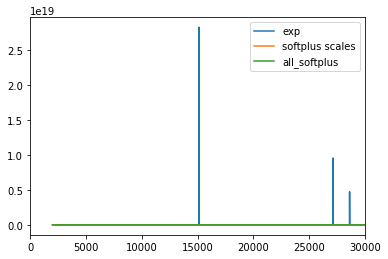

In [22]:
plt.plot(range(2000, len(mod.hist)), np.array(mod.hist)[2000:]);
plt.plot(range(2000, len(mod.hist)), np.array(mod_s.hist)[2000:]);
plt.plot(range(2000, len(mod.hist)), np.array(mod_s3.hist)[2000:]);
plt.legend(labels=['exp', 'softplus scales', 'all_softplus']);
plt.xlim(0, len(mod.hist));

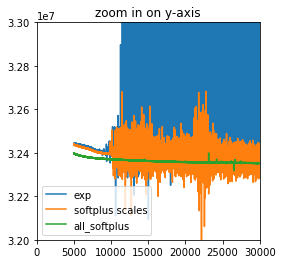

In [29]:
plt.plot(range(5000, len(mod.hist)), np.array(mod.hist)[5000:]);
plt.plot(range(5000, len(mod.hist)), np.array(mod_s.hist)[5000:]);
plt.plot(range(5000, len(mod.hist)), np.array(mod_s3.hist)[5000:]);
plt.legend(labels=['exp', 'softplus scales', 'all_softplus']);
plt.xlim(0, len(mod.hist));
plt.ylim(3.2e+7, 3.3e+7);
plt.title('zoom in on y-axis');

### Evaluate accuracy using $R^2$

In [23]:
means = mod.guide.median()
means = {k: means[k].cpu().detach().numpy() 
         for k in means.keys()}
means_softplus = mod_s.guide.median()
means_softplus = {k: means_softplus[k].cpu().detach().numpy() 
                  for k in means_softplus.keys()}
means_softplus_all = mod_s3.guide.median()
means_softplus_all = {k: means_softplus_all[k].cpu().detach().numpy() 
                  for k in means_softplus_all.keys()}

In [24]:
from re import sub
cell_count = adata_vis.obs.loc[:, ['cell_abundances_' in i for i in adata_vis.obs.columns]]
cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
cell_count_columns = cell_count.columns

infer_cell_count = pd.DataFrame(means['w_sf'], index=adata_vis.obs_names, 
                                columns=aver.columns)
infer_cell_count = infer_cell_count[cell_count.columns]

infer_cell_count_softplus = pd.DataFrame(means_softplus['w_sf'], index=adata_vis.obs_names, 
                                columns=aver.columns)
infer_cell_count_softplus = infer_cell_count_softplus[cell_count.columns]

infer_cell_count_softplus_all = pd.DataFrame(means_softplus_all['w_sf'], index=adata_vis.obs_names, 
                                columns=aver.columns)
infer_cell_count_softplus_all = infer_cell_count_softplus_all[cell_count.columns]

In [25]:
infer_cell_count.iloc[0:5,0:5], infer_cell_count_softplus.iloc[0:5,0:5], infer_cell_count_softplus_all.iloc[0:5,0:5]

(                      Inh_3   Ext_Pir   Oligo_2  Astro_HYPO   Ext_L25
 exper0_location_0  0.177210  0.884635  0.167929    0.575958  0.350269
 exper0_location_1  0.107849  1.371635  0.121778    0.344786  0.160305
 exper0_location_2  0.182473  0.403730  0.146144    0.742244  0.411611
 exper0_location_3  0.185193  0.482523  0.525760    0.568089  0.383426
 exper0_location_4  0.133373  0.891315  0.428721    0.339333  0.227337,
                       Inh_3   Ext_Pir   Oligo_2  Astro_HYPO   Ext_L25
 exper0_location_0  0.166002  0.159182  0.076220    0.318515  0.326986
 exper0_location_1  0.107559  0.687171  0.074621    0.150839  0.160628
 exper0_location_2  0.098245  0.318160  0.040792    0.258154  0.210755
 exper0_location_3  0.170852  0.456958  0.332093    0.144524  0.209895
 exper0_location_4  0.125941  0.491565  0.227968    0.118504  0.140300,
                       Inh_3   Ext_Pir   Oligo_2  Astro_HYPO   Ext_L25
 exper0_location_0  0.241304  0.118862  0.096608    0.410373  0.466299
 exp

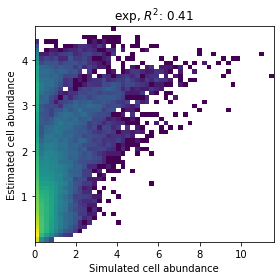

In [26]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count.values.flatten(),# / np.mean(adata_vis_res.var['gene_level'].values),
           bins=[50, 50], norm=mpl.colors.LogNorm());
plt.xlabel('Simulated cell abundance');
plt.ylabel('Estimated cell abundance');
plt.title(r'exp, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count.values.flatten()), 3)[0,1]));
#plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.savefig(fig_path + '/Cell_density_cor.pdf')

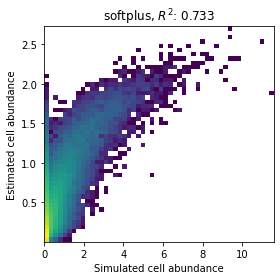

In [27]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count_softplus.values.flatten(),# / np.mean(adata_vis_res.var['gene_level'].values),
           bins=[50, 50], norm=mpl.colors.LogNorm());
plt.xlabel('Simulated cell abundance');
plt.ylabel('Estimated cell abundance');
plt.title(r'softplus, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count_softplus.values.flatten()), 3)[0,1]));
#plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.savefig(fig_path + '/Cell_density_cor.pdf')

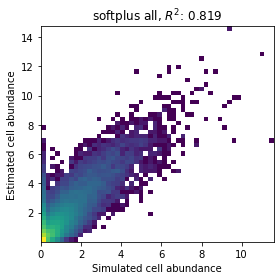

In [28]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count_softplus_all.values.flatten(),# / np.mean(adata_vis_res.var['gene_level'].values),
           bins=[50, 50], norm=mpl.colors.LogNorm());
plt.xlabel('Simulated cell abundance');
plt.ylabel('Estimated cell abundance');
plt.title(r'softplus all, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count_softplus_all.values.flatten()), 3)[0,1]));
#plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.savefig(fig_path + '/Cell_density_cor.pdf')

Original implementation of cell2location in pymc3 has $R^2 = 0.791$.

## Evaluate with PR curves

In [31]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']


def compute_precision_recall(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = precision_recall_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = average_precision_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = average_precision_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = precision_recall_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.37),
                             colors=sc.pl.palettes.default_102,
                             mode='macro', curve='PR'):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        if curve == 'PR':
            precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'Recall'
            ylabel = 'Precision'
            
            l, = plt.plot(recall["averaged"], precision["averaged"], color=color, lw=3)

        elif curve == 'ROC':
            FPR, TPR, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'FPR'
            ylabel = 'TPR'
            
            l, = plt.plot(FPR["averaged"], TPR["averaged"], color=color, lw=3)
            
        
        lines.append(l)

        labels.append(method_title[i] + '(' + curve + ' score = {0:0.2f})'
                      ''.format(average_precision["averaged"]))
        roc[method_title[i]] = average_precision["averaged"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=8))

    #plt.show()
    return roc

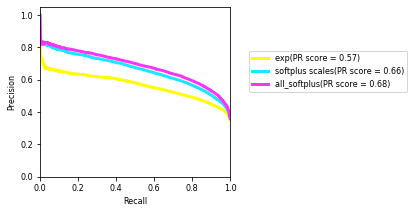

In [32]:
rcParams['figure.figsize'] = 6, 3
rcParams['font.size'] = 8

results = [
    infer_cell_count,
    infer_cell_count_softplus,
    infer_cell_count_softplus_all
]

names = [
    'exp', 
    'softplus scales', 
    'all_softplus'
]

compare_precision_recall(cell_count.values > 0.1, 
                         results,
                         method_title=names, 
                         legend_loc=(1.1, 0.5))
plt.tight_layout()

Original implementation of cell2location in pymc3 has PR score = 0.66.

In [33]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.5.3
ipykernel._version 5.5.3
json 2.0.9
re 2.2.1
IPython 7.22.0
IPython.core.release 7.22.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.8.1
pexpect 4.8.0
ptyprocess 0.7.0
decorator 5.0.6
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.18
wcwidth 0.2.5
jedi 0.18.0
parso 0.8.2
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.12
jupyter_client._version 6.1.12
zmq 22.0.3
zmq.backend.cython 40304
zmq.backend.cython.constants 40304
zmq.sugar 22.0.3
zmq.sugar.constants 40304
zmq.sugar.version 22.0.3
jupyter_core 4.7.1
jupyter_core.version 4.7.1
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.10
scanpy 1.7.2
scanpy._metadata 1.7.2
packaging 20.9
packaging.__about__ 20.9
pkg_resources._vendor.six 1.10.0
pkg_resources.extern.six 1.10.0
pkg_resources._vendor.appdirs 1.4.3
pkg_resources.extern.appdirs 1.